Student name: Ku, Shih-Chieh<br>
Student ID: 8906826

# Introduction

MNIST ("Modified National Institute of Standards and Technology") is a large database of handwritten digits that is commonly used for training various image processing systems (Wikipedia). 

The dataset are the data with 70,000 rows of MNIST digits, which is used to practice classification algorithms. Each row of MNIST digits data contains 784 columns (features), representing a number between 0 and 10 indicating a 28 * 28 pixel image.

### 1. Download the MNIST data (see class reference for optional code)

In [205]:
import seaborn as sns
import pandas as pd

from sklearn.datasets import fetch_openml
sns.set_theme(style='white', context='notebook', palette='deep')
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [206]:
mnist.data.shape, mnist.target.shape

X = pd.DataFrame(mnist.data)
y = pd.DataFrame(mnist.target)

In [207]:
y.rename(columns={0: "target"}, inplace=True)
y["target"]= y["target"].astype(int)
y.dtypes

target    int32
dtype: object

# Data Exploration (EDA)

### Run an EDA. This time, the data we work with are images. It is a different type of data than everything we worked on before. What would be a suitable EDA?

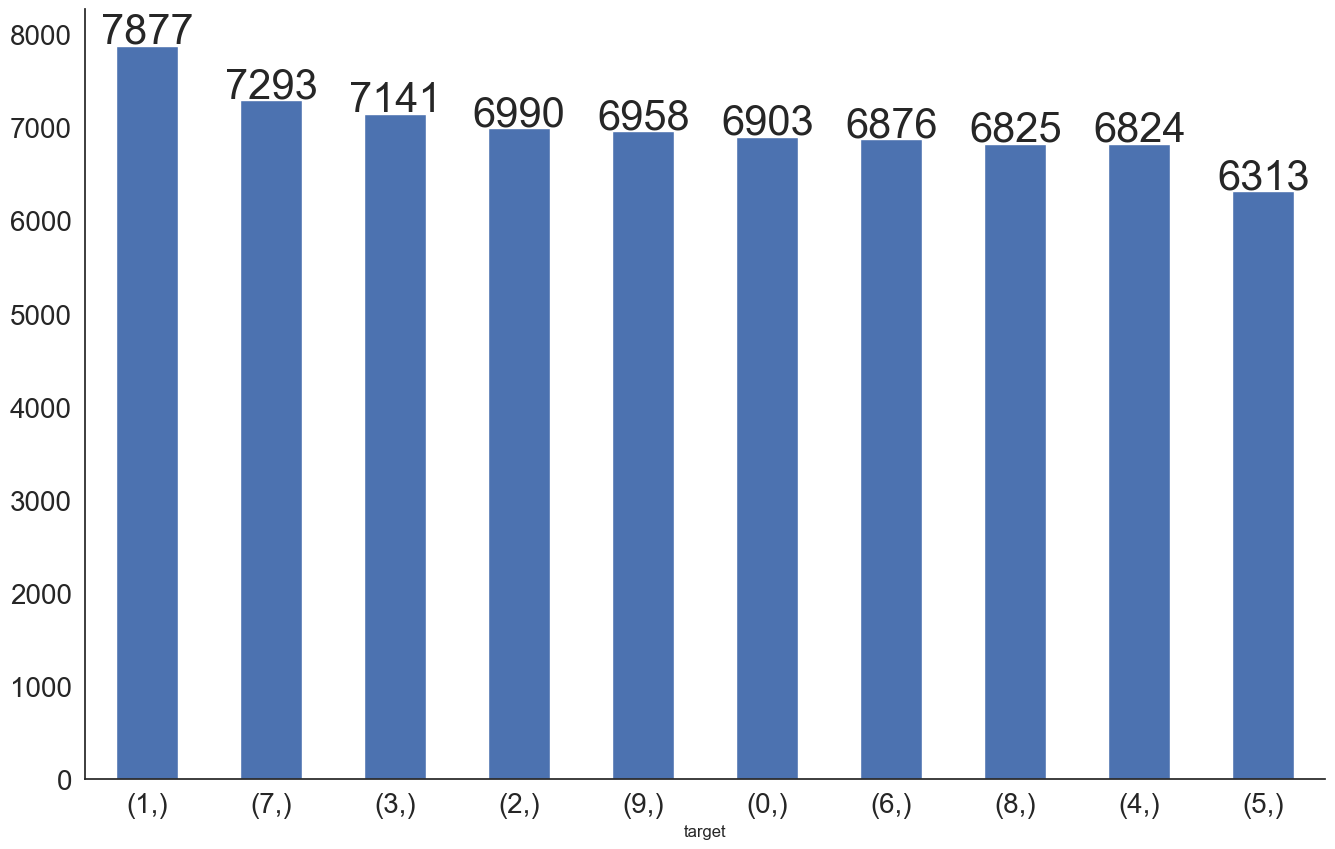

In [208]:
# Following graphic is referenced from https://www.kaggle.com/code/ohseokkim/mnist-let-s-see-it-from-a-new-perspective
import matplotlib.pyplot as plt

plt.figure(figsize = (16,10))
ax = y.value_counts().sort_values(ascending=False).plot(
    kind="bar", grid=False, fontsize=20
)

plt.xticks(rotation=0)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 30, height, ha = 'center', size = 30)
sns.despine()

<Axes: xlabel='count'>

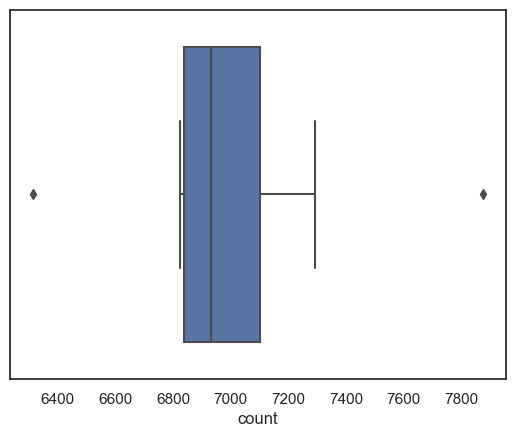

In [209]:
sns.boxplot(x=y.value_counts())

`Obsevation:`<br>
Base on the graphics, number `1` is the most **( 7877 )** and number `5` is the least **( 6313 )**, so I create a boxplot to see the distribution between them, it is obvious that the amout of number `1` and `5` are the outliers, so I decided to balance the amount of both them in the data processing part.

### Data Preprocessing

The original MNIST has 10 classes. Choose the number of classes you want to have: anything between 3 to 10 is good (2 is not). <br>

My choices are: `1`, `3`, `5`, `7`, `9`

In [210]:
indexs_13579 = y["target"].isin([1, 3, 5, 7, 9])
y_13579 = y[indexs_13579]
X_13579 = X[indexs_13579]

X_13579.shape, y_13579.shape

((35582, 784), (35582, 1))

In [211]:
X_13579.isnull().sum(), y_13579.isnull().sum()

(0      0
 1      0
 2      0
 3      0
 4      0
       ..
 779    0
 780    0
 781    0
 782    0
 783    0
 Length: 784, dtype: int64,
 target    0
 dtype: int64)

There are no null values in the dataset. Any value of 0 is considered a true value and is not treated as missing. So, no action on dealing with missing value.

As last part said, I would balance the amount of each class (0 - 10), using RandomUnderSampler function

In [212]:
# import library
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=66, replacement=True) # fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X_13579, y_13579)

print('original dataset shape:', y_13579.value_counts())
print('Resample dataset shape', y_rus.value_counts())

original dataset shape: target
1         7877
7         7293
3         7141
9         6958
5         6313
Name: count, dtype: int64
Resample dataset shape target
1         6313
3         6313
5         6313
7         6313
9         6313
Name: count, dtype: int64


### Split the dataset to train-validation-test.

Split data to train-test-validation (80%, 10%, 10%)

In [213]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_rus, y_rus, test_size=0.2, random_state=66)
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=66)

X_train.shape, X_test.shape, X_validation.shape, y_train.shape, y_test.shape, y_validation.shape

((25252, 784), (3156, 784), (3157, 784), (25252, 1), (3156, 1), (3157, 1))

### Modeling

In [214]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

model = RandomForestClassifier(random_state=66)
model.fit(X_train, np.ravel(y_train))

RandomForestClassifier(random_state=66)

### Evaluation
Accuracy

In [215]:
y_pred = model.predict(X_test)
accuracy = (y_test["target"] == y_pred).value_counts()[True] / len(y_test)

f"The accuracy calculated with test dataset is: {round(accuracy, 4) * 100}%"

'The accuracy calculated with test dataset is: 98.67%'

Confusion metric: Using 5 or non-5

In [216]:
from sklearn.metrics import confusion_matrix

pred_target = 5

y_train_specific = y_train == pred_target
y_test_specific = y_test == pred_target

model.fit(X_train, np.ravel(y_train_specific))
y_pred_5 = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test_specific, y_pred_5).ravel()


df = pd.DataFrame(
    {
        "Actual Values: Positive": [tp, fp],
        "Actual Values: Negative": [fn, tn],
    }
)

df.style.relabel_index(
    ["Predicted Values: Positive", "Predicted Values: Negative"], axis=0
)

,Actual Values: Positive,Actual Values: Negative
Predicted Values: Positive,626,15
Predicted Values: Negative,2,2513


Precision, recall and F1 for each class

In [217]:
from sklearn.metrics import classification_report

for i in range(1, 10, 2):
    y_train_specific_ = y_train == i
    y_test_specific_ = y_test == i
    
    
    model_ = RandomForestClassifier(random_state=66)

    model_.fit(X_train, np.ravel(y_train_specific_))
    y_pred_specific_ = model_.predict(X_test)

    print(
        f"Model for predict {i} or non-{i} performance: \n  {classification_report(y_test_specific_, np.ravel(y_pred_specific_))}"
    )

Model for predict 1 or non-1 performance: 
                precision    recall  f1-score   support

       False       1.00      1.00      1.00      2537
        True       1.00      0.98      0.99       619

    accuracy                           1.00      3156
   macro avg       1.00      0.99      0.99      3156
weighted avg       1.00      1.00      1.00      3156

Model for predict 3 or non-3 performance: 
                precision    recall  f1-score   support

       False       0.99      1.00      0.99      2523
        True       0.99      0.96      0.98       633

    accuracy                           0.99      3156
   macro avg       0.99      0.98      0.99      3156
weighted avg       0.99      0.99      0.99      3156

Model for predict 5 or non-5 performance: 
                precision    recall  f1-score   support

       False       0.99      1.00      1.00      2515
        True       1.00      0.98      0.99       641

    accuracy                           0.99    

Precision-recall curve for one class of your choice vs. all others

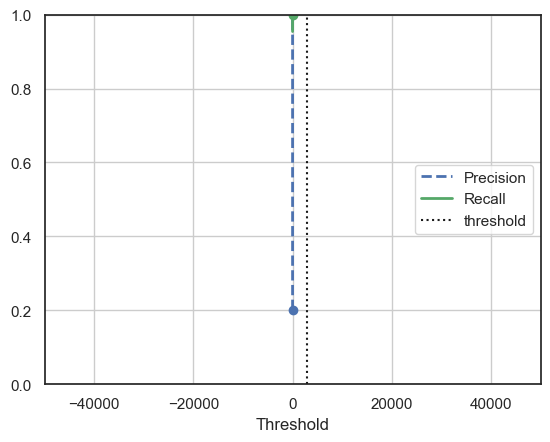

In [218]:
### The following code is referenced from https://github.com/CSCN8010/CSCN8010/blob/main/class_notebooks/classification-performance-metrics/performance_metrics_for_classification.ipynb
### Author by Professor Ran

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(model, X_train, np.ravel(y_train_specific), cv=3)
precisions, recalls, thresholds = precision_recall_curve(y_train_specific, y_scores)
threshold = 3000

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

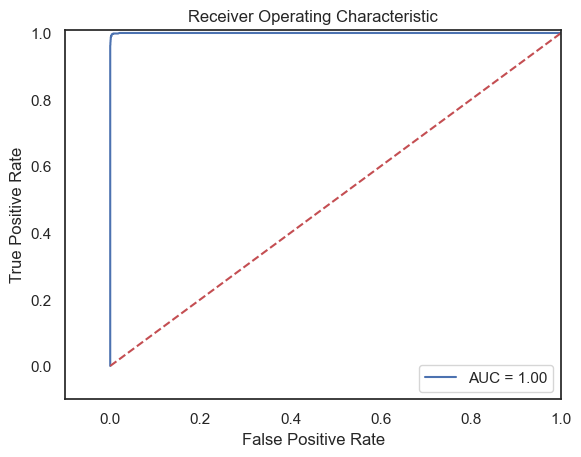

In [219]:
### The following code is referenced from https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now
from sklearn.metrics import auc, roc_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_specific, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.01])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

> `Obsevation:`<br> I chose Random Forest Classification as my training model, which is a highly suitable model for this dataset. The accuracy on the test data is approximately 99%. When examining the four indicators—**accuracy**, **precision**, **recall**, and **F1-score**— for each class (`1`, `3`, `5`, `7`, `9`), they average around 99%, indicating a significantly high level of performance. <br><br> Furthermore, based on the **ROC curve**, we observe that it is positioned close to the upper-left corner, nearly presenting a vertical angle. The AUC value also indicates significant performance, with a value of `0.97`. This suggests that the model is effective in estimating both positive and negative samples.

### Assume that you want to increase precision for your chosen class without retraining the model - what will you do? provide a numeric Python example with the validation data and the model demonstrating this. And same question, but for increasing recall.

In [220]:
from sklearn.metrics import precision_score, recall_score
def modify_pre_rec(x, y, threshold_list: list):
    y_pred_proba_val = model.predict_proba(x)[:, 1]

    y_true = (y == 5).astype(int)

    old_precision = precision_score(y_true, y_pred_proba_val >= 0.5)
    old_recall = recall_score(y_true, y_pred_proba_val >= 0.5)

    for threshold in threshold_list:
        y_pred_adjusted = [1 if prob >= threshold else 0 for prob in y_pred_proba_val]

        adjusted_precision = precision_score(y_true, y_pred_adjusted)
        adjusted_recall = recall_score(y_true, y_pred_adjusted)

        print(f"Modify threshold from 0.5 to {threshold} ---------------------------")
        print(f"Precision: {old_precision} -> {adjusted_precision}")
        print(f"Recall: {old_recall} -> {adjusted_recall}\n")
        
modify_pre_rec(X_validation, y_validation, [0.8, 0.2])

Modify threshold from 0.5 to 0.8 ---------------------------
Precision: 0.9965635738831615 -> 1.0
Recall: 0.9747899159663865 -> 0.8285714285714286

Modify threshold from 0.5 to 0.2 ---------------------------
Precision: 0.9965635738831615 -> 0.9070121951219512
Recall: 0.9747899159663865 -> 1.0



On test data

In [221]:
modify_pre_rec(X_test, y_test, [0.6,0.1])

Modify threshold from 0.5 to 0.6 ---------------------------
Precision: 0.9968203497615262 -> 1.0
Recall: 0.9781591263650546 -> 0.9516380655226209

Modify threshold from 0.5 to 0.1 ---------------------------
Precision: 0.9968203497615262 -> 0.8124207858048162
Recall: 0.9781591263650546 -> 1.0



### Conclusions

> I created a function that put predict data, ground truth data, and thresholds list inside, then it would return the result for the change of `precision` and `recall`. The same trained model but with different predict data and ground truth data would return different `precision` and `recall`. The same situation on threshold as well, if we want to meet `precision` or `recall` 1, I used `0.8` for `precision` on validation data, but only `0.6` on test data. <br><br> In conclusion, when models serve different purposes, we can manually adjust the thresholds to fit different situations. For example, if the model is monitoring for spam emails or credit card fraud, we can lower the threshold to increase the recall rate, thereby detecting fraudulent behavior as much as possible.